cpu
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.03e+00 | test_loss: 7.37e+00 | reg: 3.00e+01 | : 100%|█| 100/100 [00:08<00:00, 11.30


saving model version 0.1
MSE: 54.3579
RMSE: 7.3728
MAE: 5.8256
MAPE: 5.9440
R²: 0.7844
fixing (0,0,0) with tanh, r2=1.0000005960464478, c=3
fixing (0,0,1) with sin, r2=1.0000005960464478, c=2
fixing (0,1,0) with cos, r2=1.0000005960464478, c=2
fixing (0,1,1) with cos, r2=1.0000005960464478, c=2
fixing (0,2,0) with x, r2=0.9978814125061035, c=1
fixing (0,2,1) with x, r2=0.9870771169662476, c=1
fixing (0,3,0) with cos, r2=0.9999997615814209, c=2
fixing (0,3,1) with sin, r2=0.9999998807907104, c=2
fixing (1,0,0) with 0, r2=0.0, c=0
fixing (1,1,0) with x, r2=0.9888988137245178, c=1
saving model version 0.2


0.535*x_3 + 14.339*sin(1.226*x_1 - 8.63) + 0.402*sin(7.352*x_4 + 4.356) - 7.332*cos(5.6*x_2 - 5.998) + 80.774

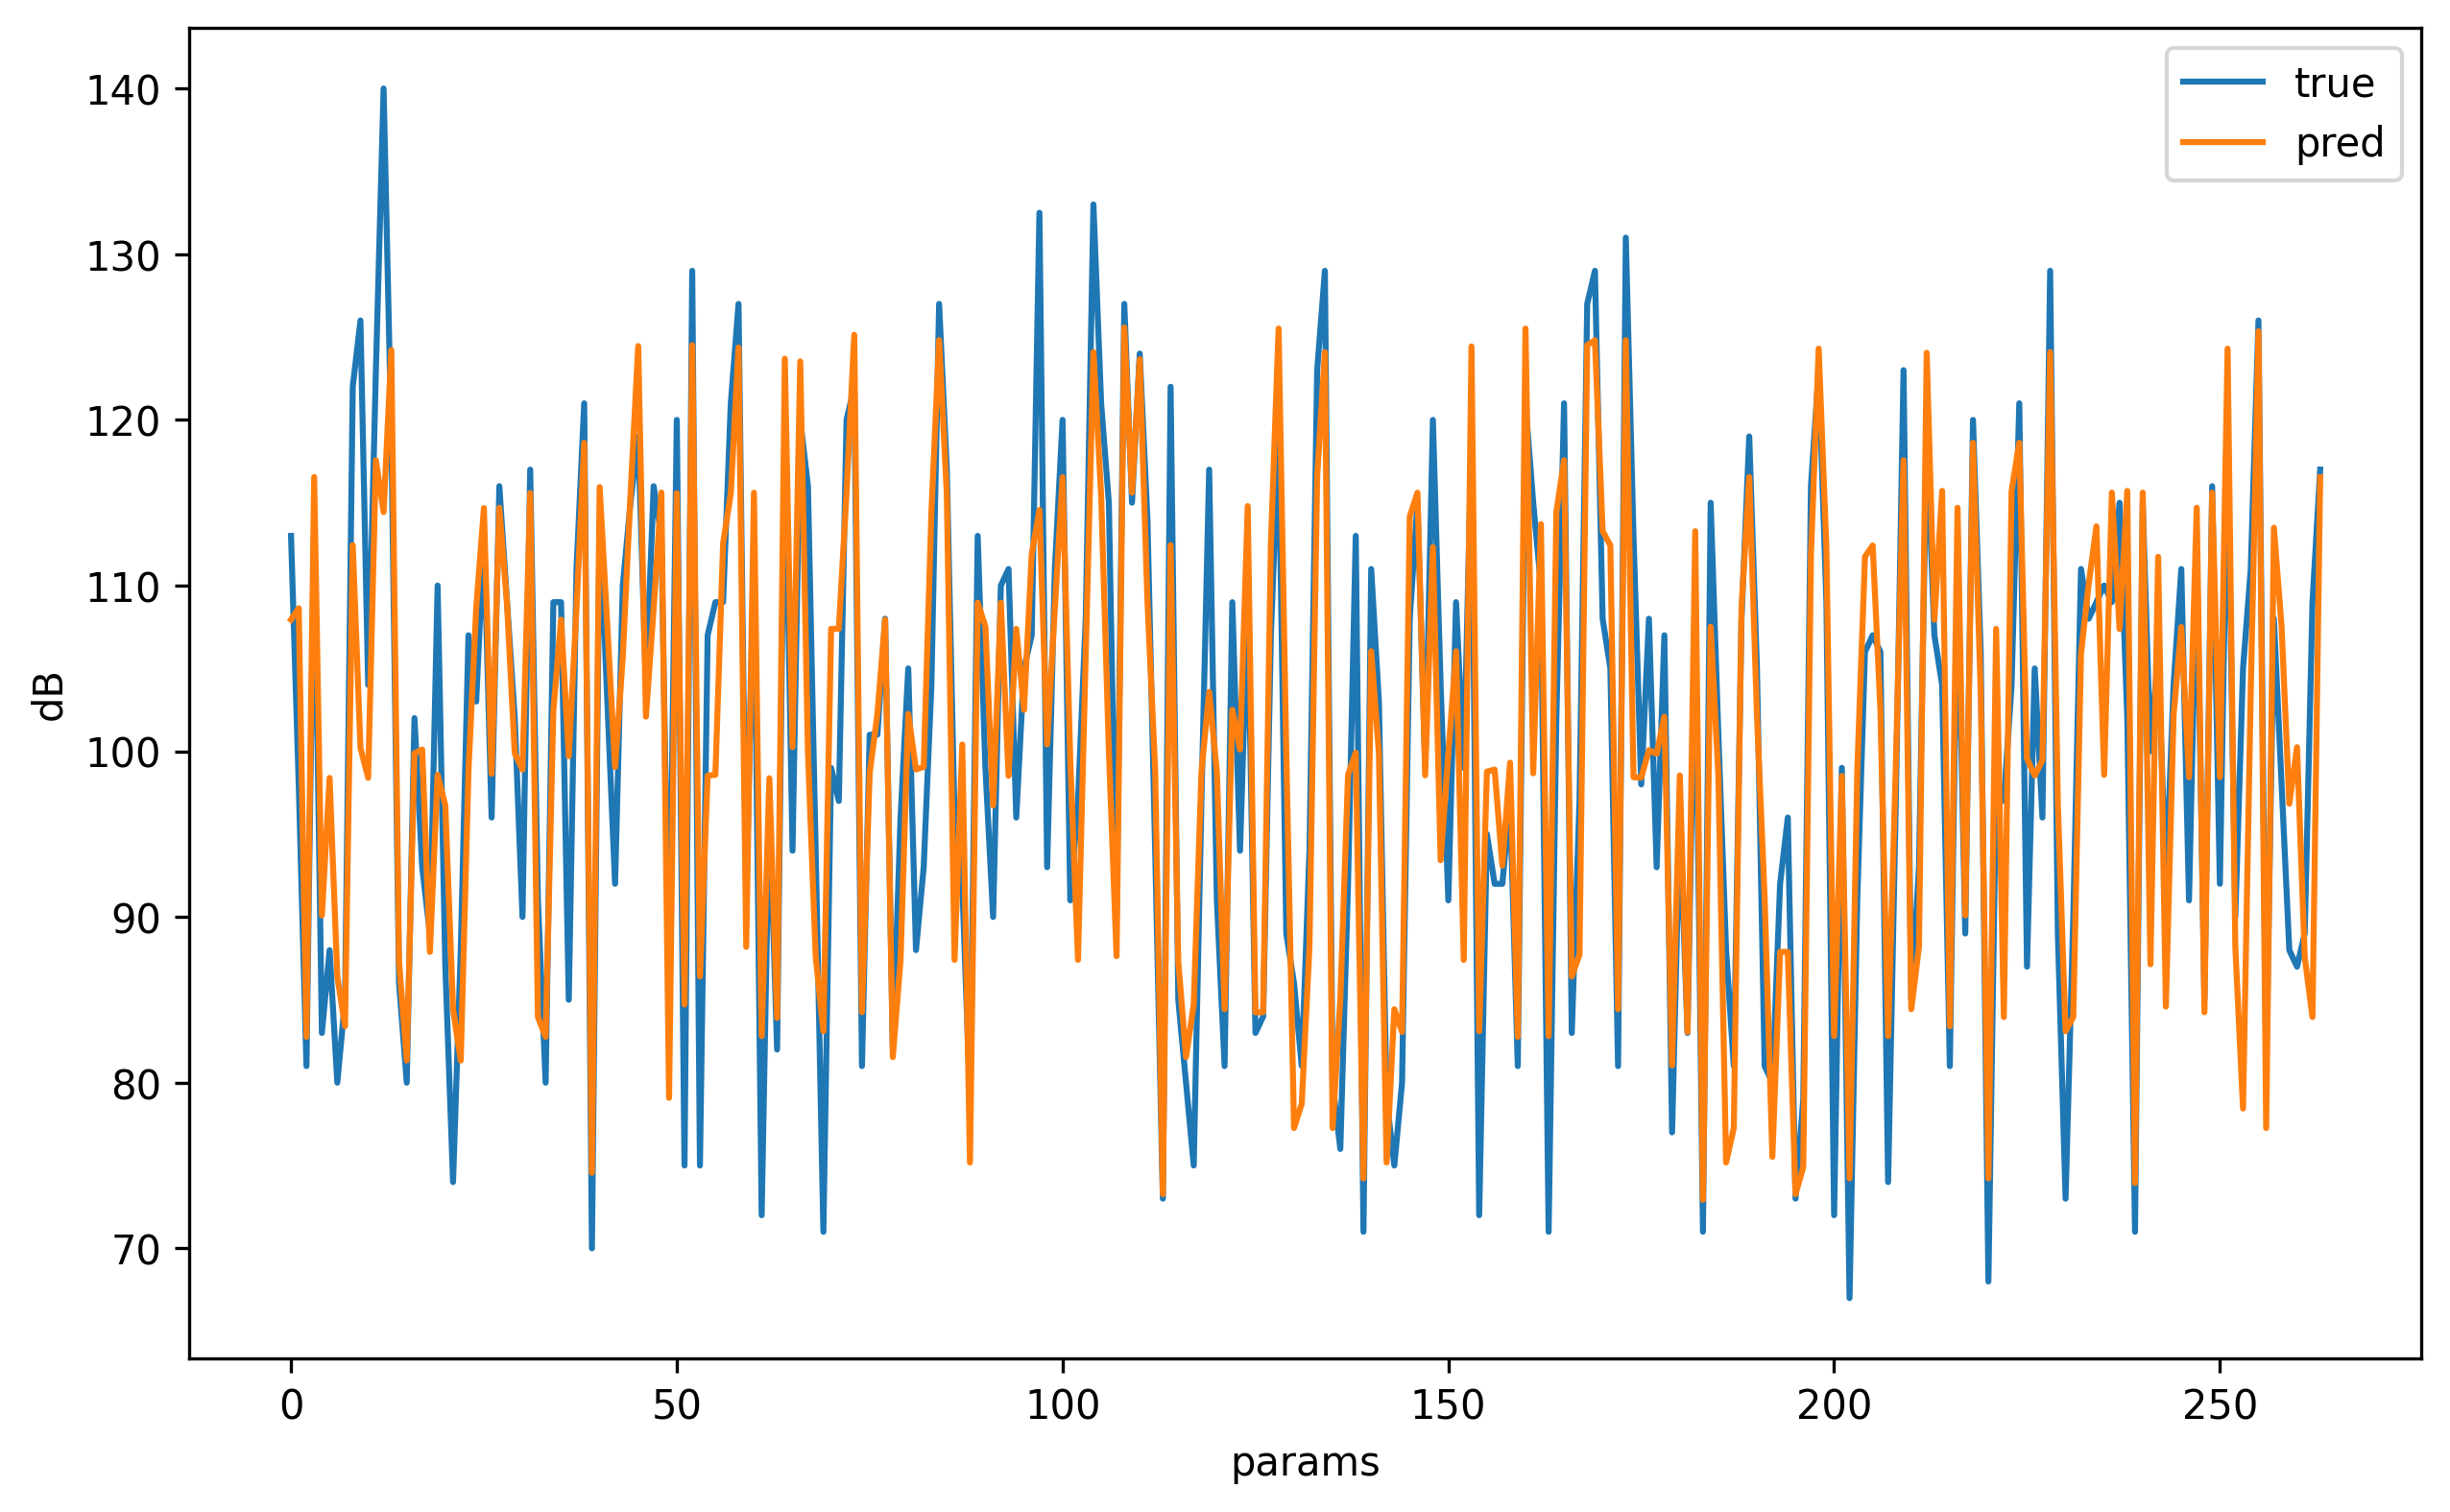

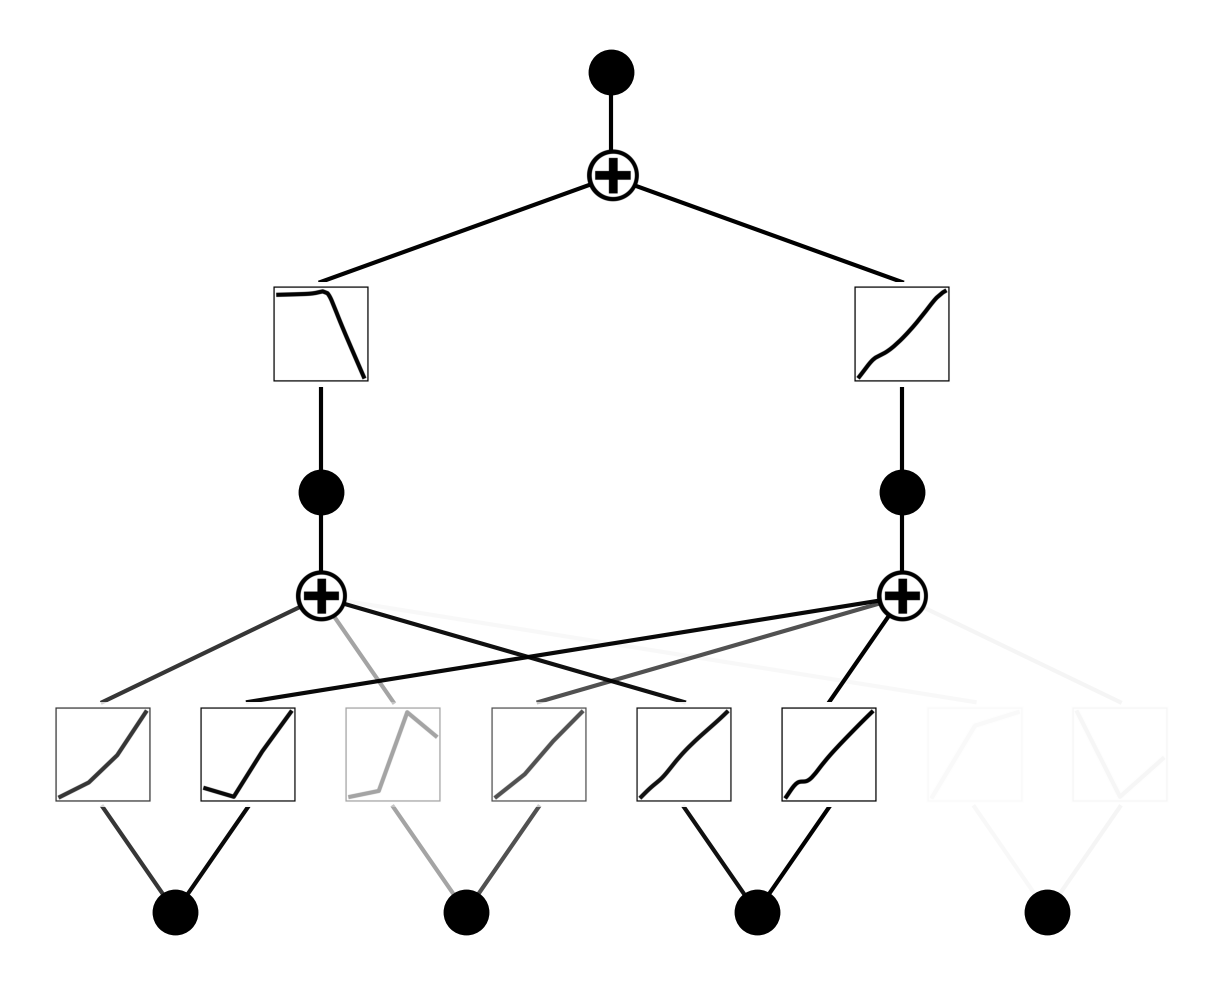

In [ ]:

from kan import *
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.dpi'] = 300

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


def eval_kan(model_kan, test_data):
    y_true = test_data['test_label']
    with torch.no_grad():
        y_pred = model_kan(test_data['test_input'])
        
    y_true = y_true.detach().cpu().numpy().ravel()
    y_pred = y_pred.detach().cpu().numpy().ravel()
    time = range(len(y_true))

    # Plot the training and test losses.
    plt.plot(time, y_true)
    plt.plot(time, y_pred)
    plt.legend(['true', 'pred'])
    plt.ylabel('dB')
    plt.xlabel('params')


    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    mape_frac = mean_absolute_percentage_error(y_true, y_pred)
    mape = mape_frac * 100
    
    # Print results
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")

    return mse, rmse, mae, mape, r2

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_gids_steps_lambda_loss(gids_size, steps, lam, metric, metric_name):
    """
    Plots a 3D scatter of gids_size vs steps vs train_loss, 
    with point color representing lambda.
    
    Parameters:
    - gids_size: array-like of shape (N,)
    - steps: array-like of shape (N,)
    - lam: array-like of shape (N,)
    - train_loss: array-like of shape (N,)
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(gids_size, steps, lam, c=metric)
    
    ax.set_xlabel('gids size')
    ax.set_ylabel('steps')
    ax.set_zlabel('lambda')
    
    plt.colorbar(sc, label='metric')
    plt.title('3D Scatter: gids size vs steps vs lambda (' + metric_name + ' as color)')
    plt.show()


# Read the data from the Excel file
indoor_data = pd.read_excel('csv_experiments.xlsx', sheet_name='Indoor', header=0)

# Assuming `inputs` and `labels` are your raw data as numpy arrays
inputs = indoor_data[['nw', 'nf', 'd', 'f']].values  # Input features (f and d)
labels = indoor_data['PL'].values    # Output labels 
train_input, test_input, train_label, test_label = train_test_split(
    inputs, labels, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
train_input = torch.tensor(train_input, dtype=torch.float32)
test_input = torch.tensor(test_input, dtype=torch.float32)

train_label = torch.tensor(train_label, dtype=torch.float32).unsqueeze(1)
test_label = torch.tensor(test_label, dtype=torch.float32).unsqueeze(1)

# Prepare the dataset dictionary
dataset = {}
dataset['train_input'] = train_input
dataset['test_input'] = test_input
dataset['train_label'] = train_label
dataset['test_label'] = test_label

model = KAN(width=[4,2,1], grid=5, k=3, seed=42, device=device)

model.fit(dataset, opt="LBFGS", steps=100, lamb=0.00002, lamb_entropy=2.);

eval_kan(model, dataset)
model.plot()

#lib = ['x', 'log', 'exp', 'sqrt', 'abs']
model.auto_symbolic()

ex_round(model.symbolic_formula()[0][0], 3)



| train_loss: 7.72e+00 | test_loss: 8.13e+00 | reg: 0.00e+00 | : 100%|█| 100/100 [00:04<00:00, 22.81


saving model version 0.3
MSE: 66.1094
RMSE: 8.1308
MAE: 6.5530
MAPE: 6.6321
R²: 0.7378


3729*x_3/10000 + 3548*sin(16897*x_1/10000 - 87787/10000)/625 + 2241*sin(918*x_4/125 + 43563/10000)/2000 - 61863*cos(18259*x_2/2500 - 125713/10000)/10000 + 812689/10000

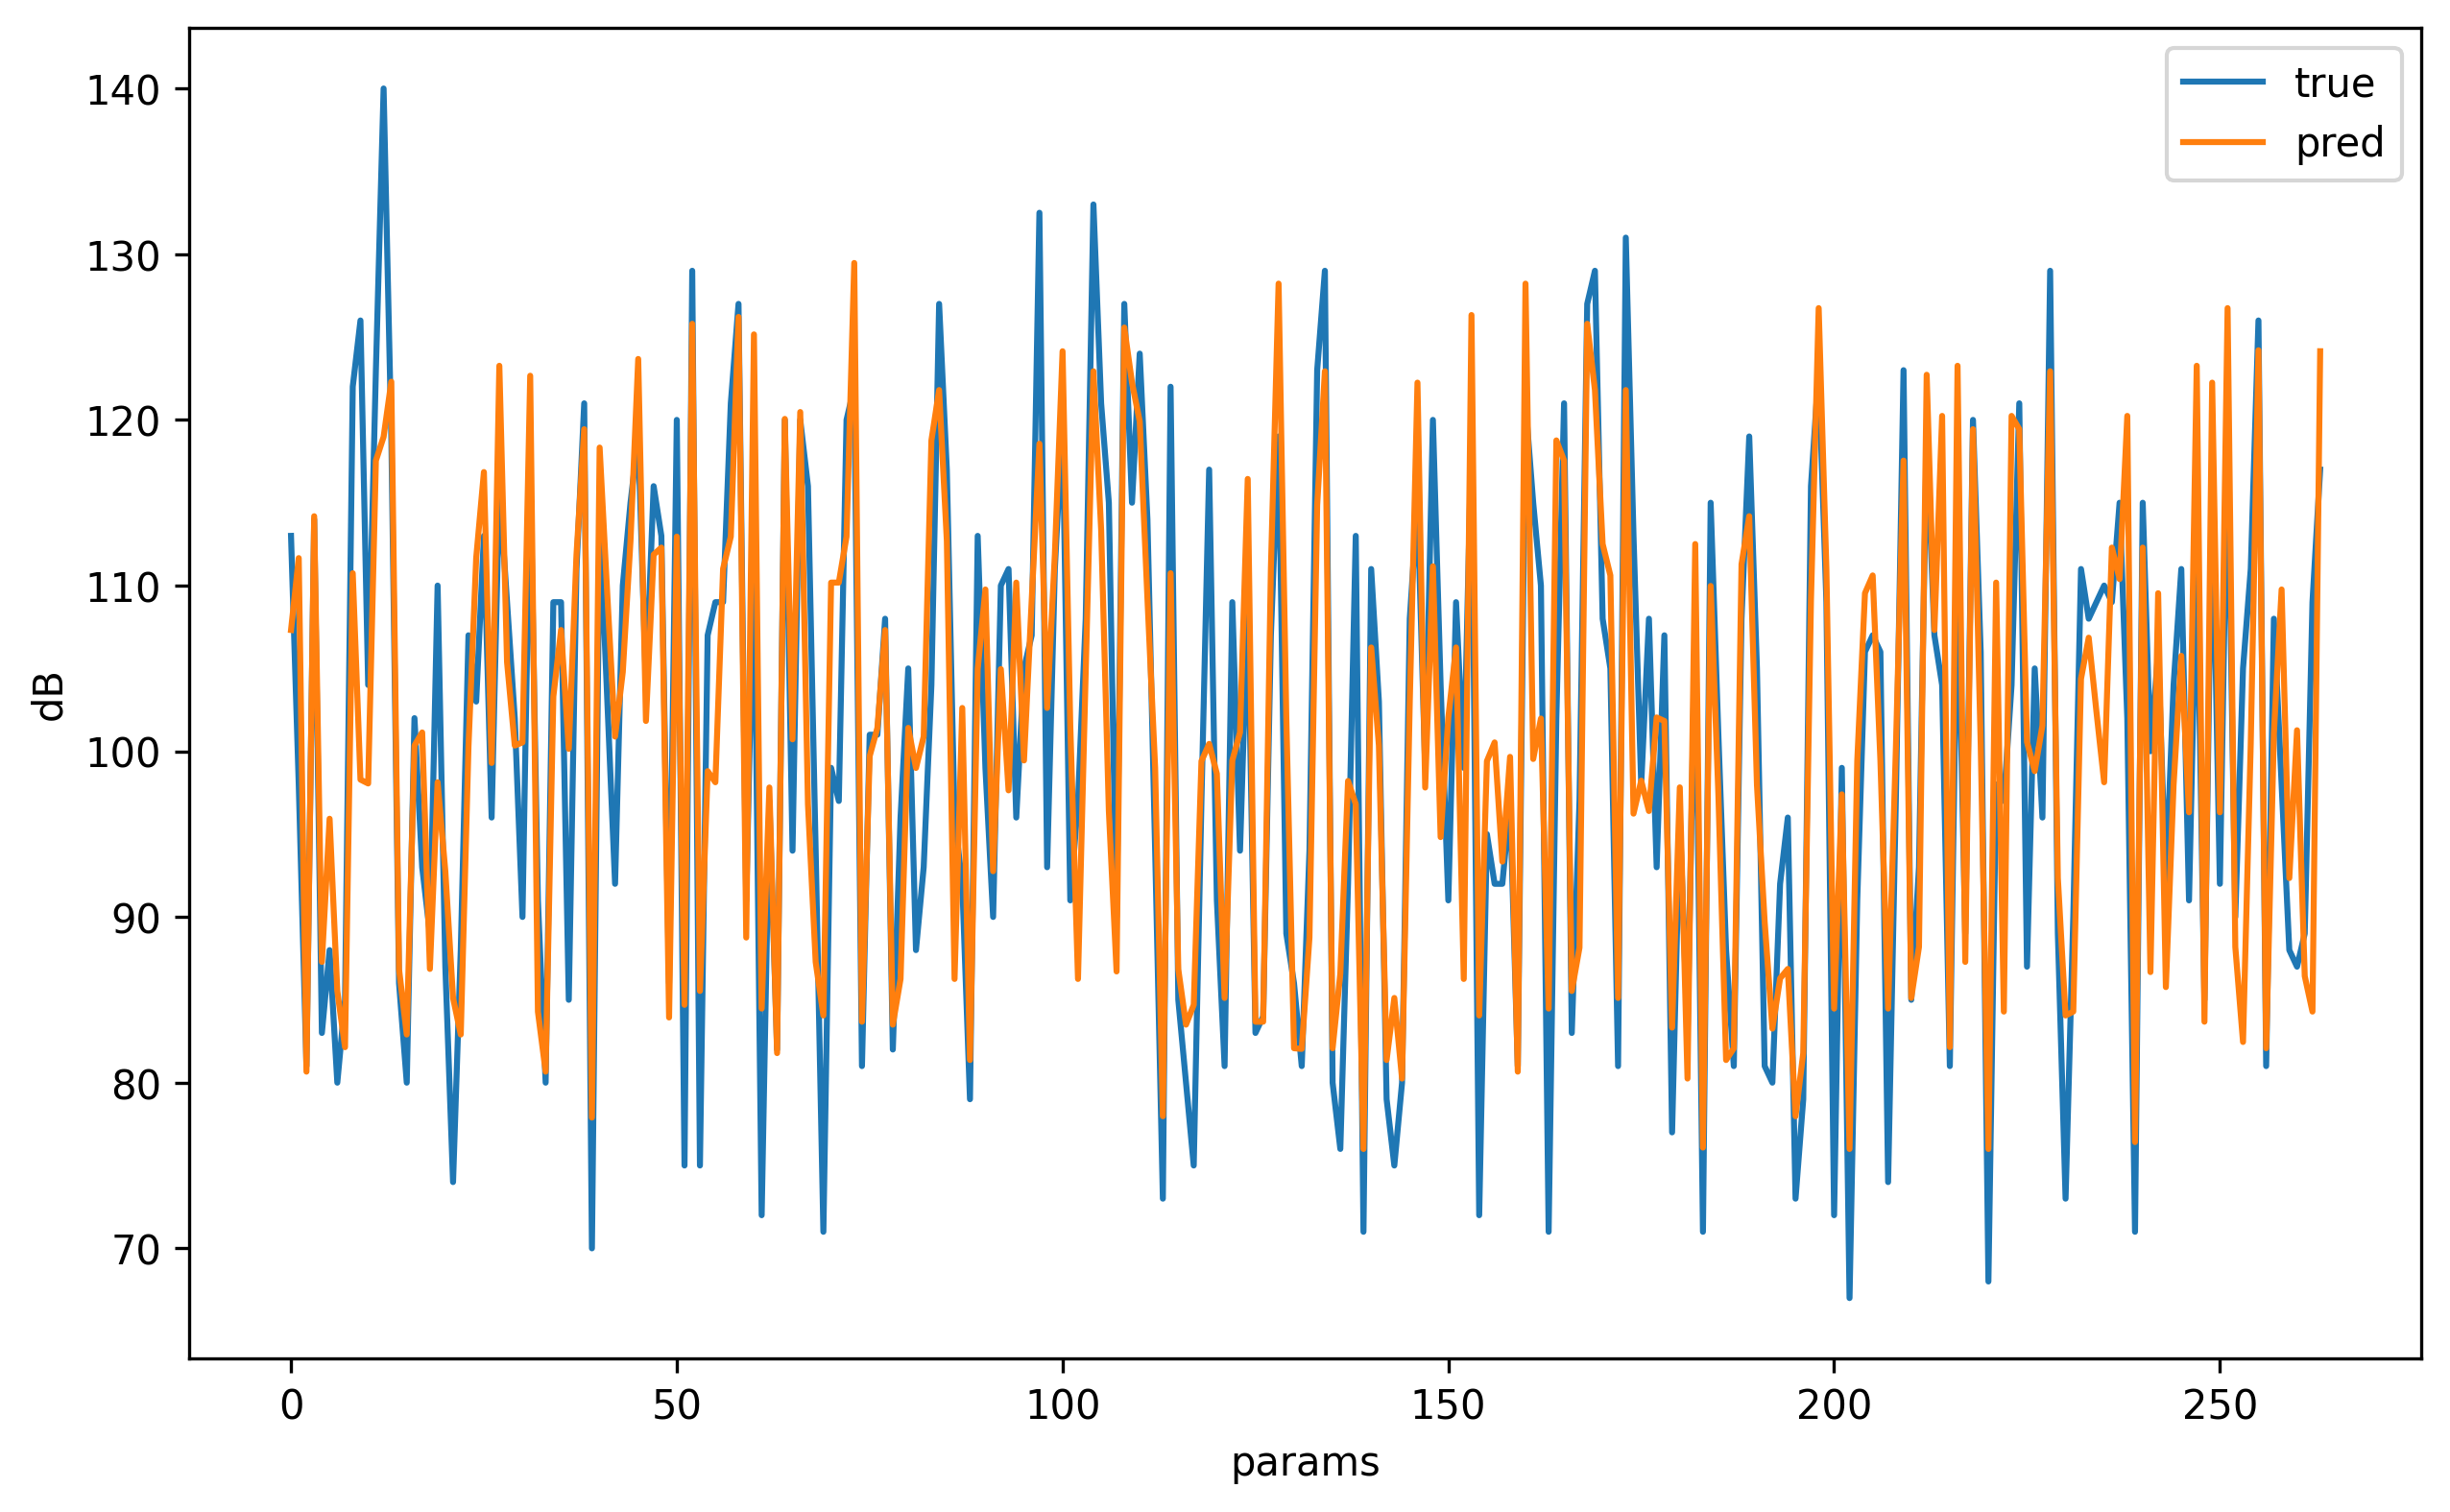

In [15]:
model.fit(dataset, opt="LBFGS", steps=100, lamb=0.0002, lamb_entropy=2.);
eval_kan(model, dataset)

formula = model.symbolic_formula()[0][0]
nsimplify(ex_round(formula, 4))

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.dpi'] = 300


# Store the training and test losses for each grid size for later plotting.
tr_losses = []
te_losses = []
plot_grids = []
plot_steps = []
plot_lambs = []
tr_maes = []
tr_mses = []
tr_mapes = []
tr_r2s = []

train_losses = []
test_losses = []

# Thee parameters for the KAN model.
grids = np.array([5, 8, 10, 15, 20, 30, 40, 50])
steps = np.array([100, 200, 300])
k = 3
lamb = np.array([0.02, 0.002, 0.0002, 0.00002])

for g in range(grids.shape[0]):
    for s in range(steps.shape[0]):
        for l in range(lamb.shape[0]):
            model= KAN(
                width=[4,1], 
                grid=grids[g], 
                k=3, 
                seed=42, 
                device=device, 
            ) 
            
            print(f"Grid size: {grids[g]}, steps {steps[s]}, {lamb[l]}")
            results = model.fit(dataset, opt="LBFGS", lamb=lamb[l], steps=steps[s], lamb_entropy=2.)
            
            train_losses += results['train_loss']
            test_losses += results['test_loss']
            #print(np.array(train_losses).mean())

            if not np.isnan(results['train_loss']).any():
                tr_mse, tr_rmse, tr_mae, tr_mape, tr_r2 = eval_kan(model, dataset);
                #te_mse, te_rmse, te_mae, te_mape, te_r2 = eval_kan(model, validation_data);

                plot_grids.append(grids[g])
                plot_steps.append(steps[s])
                plot_lambs.append(lamb[l])
                print(plot_lambs)
                
                tr_losses.append(np.array(train_losses).mean())
                te_losses.append(np.array(test_losses).mean())
                tr_maes.append(tr_mae)
                tr_mses.append(tr_mse)
                tr_mapes.append(tr_mape)
                tr_r2s.append(tr_r2)


checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 0.02


| train_loss: 7.38e+00 | test_loss: 7.73e+00 | reg: 1.36e+01 | : 100%|█| 100/100 [00:02<00:00, 46.60


saving model version 0.1
MSE: 59.7628
RMSE: 7.7306
MAE: 6.1115
MAPE: 6.2202
R²: 0.7630
[np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 0.002


| train_loss: 7.38e+00 | test_loss: 7.73e+00 | reg: 1.35e+01 | : 100%|█| 100/100 [00:02<00:00, 49.78


saving model version 0.1
MSE: 59.7849
RMSE: 7.7321
MAE: 6.1091
MAPE: 6.2111
R²: 0.7629
[np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 0.0002


| train_loss: 7.39e+00 | test_loss: 7.74e+00 | reg: 1.39e+01 | : 100%|█| 100/100 [00:02<00:00, 49.16


saving model version 0.1
MSE: 59.8668
RMSE: 7.7374
MAE: 6.1085
MAPE: 6.2169
R²: 0.7626
[np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 2e-05


| train_loss: 7.38e+00 | test_loss: 7.74e+00 | reg: 1.39e+01 | : 100%|█| 100/100 [00:02<00:00, 45.21


saving model version 0.1
MSE: 59.8855
RMSE: 7.7386
MAE: 6.0977
MAPE: 6.2008
R²: 0.7625
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 0.02


| train_loss: 7.37e+00 | test_loss: 7.71e+00 | reg: 1.35e+01 | : 100%|█| 200/200 [00:03<00:00, 53.47


saving model version 0.1
MSE: 59.4301
RMSE: 7.7091
MAE: 6.0812
MAPE: 6.1895
R²: 0.7643
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 0.002


| train_loss: 7.37e+00 | test_loss: 7.68e+00 | reg: 1.35e+01 | : 100%|█| 200/200 [00:03<00:00, 53.88


saving model version 0.1
MSE: 59.0513
RMSE: 7.6845
MAE: 6.0439
MAPE: 6.1435
R²: 0.7658
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 0.0002


| train_loss: 7.39e+00 | test_loss: 7.74e+00 | reg: 1.37e+01 | : 100%|█| 200/200 [00:03<00:00, 58.69


saving model version 0.1
MSE: 59.8516
RMSE: 7.7364
MAE: 6.1166
MAPE: 6.2253
R²: 0.7626
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 2e-05


| train_loss: 7.37e+00 | test_loss: 7.68e+00 | reg: 1.35e+01 | : 100%|█| 200/200 [00:04<00:00, 48.96


saving model version 0.1
MSE: 59.0410
RMSE: 7.6838
MAE: 6.0449
MAPE: 6.1444
R²: 0.7658
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 0.02


| train_loss: 7.37e+00 | test_loss: 7.70e+00 | reg: 1.35e+01 | : 100%|█| 300/300 [00:05<00:00, 57.58


saving model version 0.1
MSE: 59.2209
RMSE: 7.6955
MAE: 6.0570
MAPE: 6.1587
R²: 0.7651
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 0.002


| train_loss: 7.37e+00 | test_loss: 7.68e+00 | reg: 1.35e+01 | : 100%|█| 300/300 [00:05<00:00, 59.95


saving model version 0.1
MSE: 59.0496
RMSE: 7.6844
MAE: 6.0443
MAPE: 6.1440
R²: 0.7658
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 0.0002


| train_loss: 7.37e+00 | test_loss: 7.69e+00 | reg: 1.35e+01 | : 100%|█| 300/300 [00:05<00:00, 55.47


saving model version 0.1
MSE: 59.0634
RMSE: 7.6853
MAE: 6.0525
MAPE: 6.1530
R²: 0.7657
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 2e-05


| train_loss: 7.37e+00 | test_loss: 7.69e+00 | reg: 1.35e+01 | : 100%|█| 300/300 [00:05<00:00, 56.28


saving model version 0.1
MSE: 59.0622
RMSE: 7.6852
MAE: 6.0481
MAPE: 6.1478
R²: 0.7657
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 0.02


| train_loss: 7.16e+00 | test_loss: 7.48e+00 | reg: 1.30e+01 | : 100%|█| 100/100 [00:02<00:00, 39.58


saving model version 0.1
MSE: 55.9517
RMSE: 7.4801
MAE: 5.8686
MAPE: 5.9076
R²: 0.7781
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 0.002


| train_loss: 7.16e+00 | test_loss: 7.49e+00 | reg: 1.30e+01 | : 100%|█| 100/100 [00:02<00:00, 34.48


saving model version 0.1
MSE: 56.0589
RMSE: 7.4872
MAE: 5.8713
MAPE: 5.9135
R²: 0.7777
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 0.0002


| train_loss: 7.16e+00 | test_loss: 7.47e+00 | reg: 1.33e+01 | : 100%|█| 100/100 [00:03<00:00, 32.79


saving model version 0.1
MSE: 55.7866
RMSE: 7.4690
MAE: 5.8496
MAPE: 5.8940
R²: 0.7787
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 2e-05


| train_loss: 7.16e+00 | test_loss: 7.48e+00 | reg: 1.30e+01 | : 100%|█| 100/100 [00:03<00:00, 32.72


saving model version 0.1
MSE: 55.9539
RMSE: 7.4802
MAE: 5.8674
MAPE: 5.9104
R²: 0.7781
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 0.02


| train_loss: 7.16e+00 | test_loss: 7.47e+00 | reg: 1.29e+01 | : 100%|█| 200/200 [00:04<00:00, 49.19


saving model version 0.1
MSE: 55.7816
RMSE: 7.4687
MAE: 5.8580
MAPE: 5.9044
R²: 0.7788
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 0.002


| train_loss: 7.16e+00 | test_loss: 7.46e+00 | reg: 1.32e+01 | : 100%|█| 200/200 [00:04<00:00, 45.60


saving model version 0.1
MSE: 55.7110
RMSE: 7.4640
MAE: 5.8442
MAPE: 5.8886
R²: 0.7790
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 0.0002


| train_loss: 7.14e+00 | test_loss: 7.45e+00 | reg: 1.32e+01 | : 100%|█| 200/200 [00:05<00:00, 39.56


saving model version 0.1
MSE: 55.5015
RMSE: 7.4499
MAE: 5.8210
MAPE: 5.8545
R²: 0.7799
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 2e-05


| train_loss: 7.16e+00 | test_loss: 7.46e+00 | reg: 1.32e+01 | : 100%|█| 200/200 [00:04<00:00, 47.27


saving model version 0.1
MSE: 55.5792
RMSE: 7.4551
MAE: 5.8578
MAPE: 5.9100
R²: 0.7796
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 0.02


| train_loss: 7.16e+00 | test_loss: 7.47e+00 | reg: 1.29e+01 | : 100%|█| 300/300 [00:05<00:00, 59.63


saving model version 0.1
MSE: 55.7815
RMSE: 7.4687
MAE: 5.8580
MAPE: 5.9044
R²: 0.7788
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 0.002


| train_loss: 7.14e+00 | test_loss: 7.46e+00 | reg: 1.32e+01 | : 100%|█| 300/300 [00:06<00:00, 48.05


saving model version 0.1
MSE: 55.6057
RMSE: 7.4569
MAE: 5.8344
MAPE: 5.8655
R²: 0.7795
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 0.0002


| train_loss: 7.14e+00 | test_loss: 7.46e+00 | reg: 1.30e+01 | : 100%|█| 300/300 [00:06<00:00, 46.64


saving model version 0.1
MSE: 55.5866
RMSE: 7.4556
MAE: 5.8337
MAPE: 5.8701
R²: 0.7795
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 2e-05


| train_loss: 7.14e+00 | test_loss: 7.47e+00 | reg: 1.31e+01 | : 100%|█| 300/300 [00:06<00:00, 49.83


saving model version 0.1
MSE: 55.7745
RMSE: 7.4682
MAE: 5.8536
MAPE: 5.8974
R²: 0.7788
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 100, 0.02


| train_loss: 6.93e+00 | test_loss: 7.33e+00 | reg: 1.27e+01 | : 100%|█| 100/100 [00:03<00:00, 33.23


saving model version 0.1
MSE: 53.7371
RMSE: 7.3306
MAE: 5.8441
MAPE: 5.8666
R²: 0.7869
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 100, 0.002


| train_loss: 6.93e+00 | test_loss: 7.34e+00 | reg: 1.29e+01 | : 100%|█| 100/100 [00:02<00:00, 34.11


saving model version 0.1
MSE: 53.8618
RMSE: 7.3391
MAE: 5.8540
MAPE: 5.8782
R²: 0.7864
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 100, 0.0002


| train_loss: 6.93e+00 | test_loss: 7.34e+00 | reg: 1.29e+01 | : 100%|█| 100/100 [00:02<00:00, 35.80


saving model version 0.1
MSE: 53.8864
RMSE: 7.3407
MAE: 5.8578
MAPE: 5.8853
R²: 0.7863
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 100, 2e-05


| train_loss: 6.93e+00 | test_loss: 7.34e+00 | reg: 1.28e+01 | : 100%|█| 100/100 [00:02<00:00, 36.67


saving model version 0.1
MSE: 53.8315
RMSE: 7.3370
MAE: 5.8594
MAPE: 5.8895
R²: 0.7865
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 200, 0.02


| train_loss: 6.92e+00 | test_loss: 7.34e+00 | reg: 1.27e+01 | : 100%|█| 200/200 [00:04<00:00, 40.31


saving model version 0.1
MSE: 53.9351
RMSE: 7.3441
MAE: 5.8526
MAPE: 5.8798
R²: 0.7861
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 200, 0.002


| train_loss: 6.93e+00 | test_loss: 7.33e+00 | reg: 1.28e+01 | : 100%|█| 200/200 [00:04<00:00, 45.54


saving model version 0.1
MSE: 53.7606
RMSE: 7.3322
MAE: 5.8425
MAPE: 5.8644
R²: 0.7868
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 200, 0.0002


| train_loss: 6.93e+00 | test_loss: 7.34e+00 | reg: 1.29e+01 | : 100%|█| 200/200 [00:04<00:00, 46.10


saving model version 0.1
MSE: 53.8864
RMSE: 7.3407
MAE: 5.8578
MAPE: 5.8853
R²: 0.7863
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 200, 2e-05


| train_loss: 6.93e+00 | test_loss: 7.34e+00 | reg: 1.29e+01 | : 100%|█| 200/200 [00:04<00:00, 46.89


saving model version 0.1
MSE: 53.9010
RMSE: 7.3417
MAE: 5.8560
MAPE: 5.8799
R²: 0.7862
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 300, 0.02


| train_loss: 6.92e+00 | test_loss: 7.32e+00 | reg: 1.26e+01 | : 100%|█| 300/300 [00:06<00:00, 46.62


saving model version 0.1
MSE: 53.5902
RMSE: 7.3205
MAE: 5.8173
MAPE: 5.8460
R²: 0.7875
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 300, 0.002


| train_loss: 6.92e+00 | test_loss: 7.33e+00 | reg: 1.30e+01 | : 100%|█| 300/300 [00:05<00:00, 50.76


saving model version 0.1
MSE: 53.7784
RMSE: 7.3334
MAE: 5.8200
MAPE: 5.8413
R²: 0.7867
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 300, 0.0002


| train_loss: 6.93e+00 | test_loss: 7.34e+00 | reg: 1.29e+01 | : 100%|█| 300/300 [00:05<00:00, 53.99


saving model version 0.1
MSE: 53.8864
RMSE: 7.3407
MAE: 5.8578
MAPE: 5.8853
R²: 0.7863
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 300, 2e-05


| train_loss: 6.93e+00 | test_loss: 7.34e+00 | reg: 1.29e+01 | : 100%|█| 300/300 [00:05<00:00, 54.12


saving model version 0.1
MSE: 53.9010
RMSE: 7.3417
MAE: 5.8560
MAPE: 5.8799
R²: 0.7862
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 100, 0.02


| train_loss: 6.38e+00 | test_loss: 6.63e+00 | reg: 1.26e+01 | : 100%|█| 100/100 [00:02<00:00, 33.52


saving model version 0.1
MSE: 44.0003
RMSE: 6.6333
MAE: 5.1740
MAPE: 5.1654
R²: 0.8255
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 100, 0.002


| train_loss: 6.37e+00 | test_loss: 6.64e+00 | reg: 1.28e+01 | : 100%|█| 100/100 [00:02<00:00, 36.25


saving model version 0.1
MSE: 44.0446
RMSE: 6.6366
MAE: 5.1760
MAPE: 5.1684
R²: 0.8253
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 100, 0.0002


| train_loss: 6.38e+00 | test_loss: 6.64e+00 | reg: 1.28e+01 | : 100%|█| 100/100 [00:02<00:00, 34.63


saving model version 0.1
MSE: 44.0544
RMSE: 6.6374
MAE: 5.1827
MAPE: 5.1761
R²: 0.8253
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 100, 2e-05


| train_loss: 6.38e+00 | test_loss: 6.66e+00 | reg: 1.29e+01 | : 100%|█| 100/100 [00:02<00:00, 34.66


saving model version 0.1
MSE: 44.3346
RMSE: 6.6584
MAE: 5.1917
MAPE: 5.1821
R²: 0.8242
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 200, 0.02


| train_loss: 6.37e+00 | test_loss: 6.63e+00 | reg: 1.26e+01 | : 100%|█| 200/200 [00:04<00:00, 48.10


saving model version 0.1
MSE: 43.9731
RMSE: 6.6312
MAE: 5.1738
MAPE: 5.1659
R²: 0.8256
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 200, 0.002


| train_loss: 6.37e+00 | test_loss: 6.63e+00 | reg: 1.28e+01 | : 100%|█| 200/200 [00:04<00:00, 48.47


saving model version 0.1
MSE: 44.0158
RMSE: 6.6344
MAE: 5.1750
MAPE: 5.1676
R²: 0.8254
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 200, 0.0002


| train_loss: 6.37e+00 | test_loss: 6.63e+00 | reg: 1.29e+01 | : 100%|█| 200/200 [00:04<00:00, 47.82


saving model version 0.1
MSE: 44.0113
RMSE: 6.6341
MAE: 5.1754
MAPE: 5.1686
R²: 0.8254
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15, steps 200, 2e-05


| train_loss: 6.37e+00 | test_loss: 6.64e+00 | reg: 1.28e+01 | : 100%|█| 200/200 [00:04<00:00, 47.95


saving model version 0.1
MSE: 44.0804
RMSE: 6.6393
MAE: 5.1789
MAPE: 5.1710
R²: 0.8252
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 15

| train_loss: 6.37e+00 | test_loss: 6.63e+00 | reg: 1.26e+01 | : 100%|█| 300/300 [00:05<00:00, 57.01


saving model version 0.1
MSE: 43.9731
RMSE: 6.6312
MAE: 5.1738
MAPE: 5.1659
R²: 0.8256
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02)]
checkpoint directory created: ./model
saving model version

| train_loss: 6.37e+00 | test_loss: 6.63e+00 | reg: 1.28e+01 | : 100%|█| 300/300 [00:05<00:00, 54.11


saving model version 0.1
MSE: 43.9844
RMSE: 6.6321
MAE: 5.1719
MAPE: 5.1644
R²: 0.8256
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
s

| train_loss: 6.37e+00 | test_loss: 6.63e+00 | reg: 1.29e+01 | : 100%|█| 300/300 [00:05<00:00, 57.19


saving model version 0.1
MSE: 43.9170
RMSE: 6.6270
MAE: 5.1653
MAPE: 5.1565
R²: 0.8258
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint director

| train_loss: 6.37e+00 | test_loss: 6.63e+00 | reg: 1.29e+01 | : 100%|█| 300/300 [00:06<00:00, 48.04


saving model version 0.1
MSE: 43.9184
RMSE: 6.6271
MAE: 5.1652
MAPE: 5.1578
R²: 0.8258
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]


| train_loss: 6.13e+00 | test_loss: 6.24e+00 | reg: 1.32e+01 | : 100%|█| 100/100 [00:02<00:00, 33.53


saving model version 0.1
MSE: 38.8951
RMSE: 6.2366
MAE: 4.8748
MAPE: 4.8347
R²: 0.8457
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.13e+00 | test_loss: 6.25e+00 | reg: 1.32e+01 | : 100%|█| 100/100 [00:02<00:00, 33.70


saving model version 0.1
MSE: 39.0249
RMSE: 6.2470
MAE: 4.8688
MAPE: 4.8275
R²: 0.8452
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.14e+00 | test_loss: 6.26e+00 | reg: 1.33e+01 | : 100%|█| 100/100 [00:02<00:00, 33.40


saving model version 0.1
MSE: 39.1529
RMSE: 6.2572
MAE: 4.8914
MAPE: 4.8504
R²: 0.8447
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.13e+00 | test_loss: 6.23e+00 | reg: 1.34e+01 | : 100%|█| 100/100 [00:02<00:00, 34.23


saving model version 0.1
MSE: 38.8657
RMSE: 6.2342
MAE: 4.8679
MAPE: 4.8288
R²: 0.8459
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.13e+00 | test_loss: 6.24e+00 | reg: 1.32e+01 | : 100%|█| 200/200 [00:04<00:00, 43.29


saving model version 0.1
MSE: 38.9326
RMSE: 6.2396
MAE: 4.8680
MAPE: 4.8292
R²: 0.8456
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.13e+00 | test_loss: 6.25e+00 | reg: 1.32e+01 | : 100%|█| 200/200 [00:04<00:00, 45.22


saving model version 0.1
MSE: 39.0332
RMSE: 6.2477
MAE: 4.8728
MAPE: 4.8325
R²: 0.8452
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.13e+00 | test_loss: 6.24e+00 | reg: 1.34e+01 | : 100%|█| 200/200 [00:04<00:00, 45.46


saving model version 0.1
MSE: 38.9009
RMSE: 6.2371
MAE: 4.8516
MAPE: 4.8106
R²: 0.8457
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.13e+00 | test_loss: 6.24e+00 | reg: 1.35e+01 | : 100%|█| 200/200 [00:04<00:00, 47.07


saving model version 0.1
MSE: 38.8974
RMSE: 6.2368
MAE: 4.8599
MAPE: 4.8196
R²: 0.8457
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.13e+00 | test_loss: 6.24e+00 | reg: 1.32e+01 | : 100%|█| 300/300 [00:05<00:00, 53.20


saving model version 0.1
MSE: 38.8979
RMSE: 6.2368
MAE: 4.8649
MAPE: 4.8255
R²: 0.8457
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.13e+00 | test_loss: 6.25e+00 | reg: 1.33e+01 | : 100%|█| 300/300 [00:05<00:00, 53.03


saving model version 0.1
MSE: 39.0608
RMSE: 6.2499
MAE: 4.8686
MAPE: 4.8265
R²: 0.8451
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.13e+00 | test_loss: 6.25e+00 | reg: 1.34e+01 | : 100%|█| 300/300 [00:05<00:00, 50.64


saving model version 0.1
MSE: 39.0094
RMSE: 6.2458
MAE: 4.8690
MAPE: 4.8264
R²: 0.8453
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 6.13e+00 | test_loss: 6.24e+00 | reg: 1.35e+01 | : 100%|█| 300/300 [00:05<00:00, 55.89


saving model version 0.1
MSE: 38.8955
RMSE: 6.2366
MAE: 4.8597
MAPE: 4.8194
R²: 0.8457
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.76e+00 | test_loss: 6.05e+00 | reg: 1.35e+01 | : 100%|█| 100/100 [00:04<00:00, 23.68


saving model version 0.1
MSE: 36.6411
RMSE: 6.0532
MAE: 4.6543
MAPE: 4.6359
R²: 0.8547
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.78e+00 | test_loss: 6.02e+00 | reg: 1.33e+01 | : 100%|█| 100/100 [00:04<00:00, 24.71


saving model version 0.1
MSE: 36.2952
RMSE: 6.0245
MAE: 4.6334
MAPE: 4.6170
R²: 0.8560
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.75e+00 | test_loss: 6.04e+00 | reg: 1.37e+01 | : 100%|█| 100/100 [00:04<00:00, 23.80


saving model version 0.1
MSE: 36.4810
RMSE: 6.0399
MAE: 4.6509
MAPE: 4.6336
R²: 0.8553
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.76e+00 | test_loss: 6.04e+00 | reg: 1.39e+01 | : 100%|█| 100/100 [00:04<00:00, 23.90


saving model version 0.1
MSE: 36.4674
RMSE: 6.0388
MAE: 4.6495
MAPE: 4.6304
R²: 0.8554
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.75e+00 | test_loss: 6.03e+00 | reg: 1.32e+01 | : 100%|█| 200/200 [00:06<00:00, 30.33


saving model version 0.1
MSE: 36.3502
RMSE: 6.0291
MAE: 4.6303
MAPE: 4.6071
R²: 0.8558
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.75e+00 | test_loss: 6.04e+00 | reg: 1.39e+01 | : 100%|█| 200/200 [00:06<00:00, 31.01


saving model version 0.1
MSE: 36.4398
RMSE: 6.0365
MAE: 4.6522
MAPE: 4.6336
R²: 0.8555
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.75e+00 | test_loss: 6.05e+00 | reg: 1.38e+01 | : 100%|█| 200/200 [00:05<00:00, 33.41


saving model version 0.1
MSE: 36.5949
RMSE: 6.0494
MAE: 4.6558
MAPE: 4.6362
R²: 0.8549
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.72e+00 | test_loss: 5.98e+00 | reg: 1.36e+01 | : 100%|█| 200/200 [00:06<00:00, 30.26


saving model version 0.1
MSE: 35.8162
RMSE: 5.9847
MAE: 4.5810
MAPE: 4.5425
R²: 0.8579
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.73e+00 | test_loss: 5.99e+00 | reg: 1.35e+01 | : 100%|█| 300/300 [00:08<00:00, 34.99


saving model version 0.1
MSE: 35.8354
RMSE: 5.9863
MAE: 4.6047
MAPE: 4.5736
R²: 0.8579
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.73e+00 | test_loss: 6.01e+00 | reg: 1.37e+01 | : 100%|█| 300/300 [00:08<00:00, 34.12


saving model version 0.1
MSE: 36.0884
RMSE: 6.0074
MAE: 4.6095
MAPE: 4.5731
R²: 0.8569
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.73e+00 | test_loss: 5.98e+00 | reg: 1.37e+01 | : 100%|█| 300/300 [00:08<00:00, 35.16


saving model version 0.1
MSE: 35.8057
RMSE: 5.9838
MAE: 4.5868
MAPE: 4.5486
R²: 0.8580
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.68e+00 | test_loss: 5.97e+00 | reg: 1.36e+01 | : 100%|█| 300/300 [00:10<00:00, 29.28


saving model version 0.1
MSE: 35.6870
RMSE: 5.9739
MAE: 4.5649
MAPE: 4.5190
R²: 0.8585
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.45e+00 | test_loss: 5.79e+00 | reg: 1.33e+01 | : 100%|█| 100/100 [00:04<00:00, 22.84


saving model version 0.1
MSE: 33.5012
RMSE: 5.7880
MAE: 4.3865
MAPE: 4.3491
R²: 0.8671
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.46e+00 | test_loss: 5.78e+00 | reg: 1.40e+01 | : 100%|█| 100/100 [00:04<00:00, 22.57


saving model version 0.1
MSE: 33.3967
RMSE: 5.7790
MAE: 4.3768
MAPE: 4.3333
R²: 0.8675
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.46e+00 | test_loss: 5.78e+00 | reg: 1.41e+01 | : 100%|█| 100/100 [00:05<00:00, 18.39


saving model version 0.1
MSE: 33.4216
RMSE: 5.7811
MAE: 4.3773
MAPE: 4.3382
R²: 0.8674
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.45e+00 | test_loss: 5.79e+00 | reg: 1.39e+01 | : 100%|█| 100/100 [00:07<00:00, 13.22


saving model version 0.1
MSE: 33.4946
RMSE: 5.7874
MAE: 4.3780
MAPE: 4.3392
R²: 0.8672
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.45e+00 | test_loss: 5.79e+00 | reg: 1.32e+01 | : 100%|█| 200/200 [00:07<00:00, 26.41


saving model version 0.1
MSE: 33.5794
RMSE: 5.7948
MAE: 4.3916
MAPE: 4.3535
R²: 0.8668
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.45e+00 | test_loss: 5.79e+00 | reg: 1.36e+01 | : 100%|█| 200/200 [00:06<00:00, 30.25


saving model version 0.1
MSE: 33.5357
RMSE: 5.7910
MAE: 4.3831
MAPE: 4.3462
R²: 0.8670
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.45e+00 | test_loss: 5.78e+00 | reg: 1.38e+01 | : 100%|█| 200/200 [00:06<00:00, 29.83


saving model version 0.1
MSE: 33.3559
RMSE: 5.7755
MAE: 4.3664
MAPE: 4.3242
R²: 0.8677
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.45e+00 | test_loss: 5.79e+00 | reg: 1.37e+01 | : 100%|█| 200/200 [00:06<00:00, 33.24


saving model version 0.1
MSE: 33.5173
RMSE: 5.7894
MAE: 4.3784
MAPE: 4.3396
R²: 0.8671
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.45e+00 | test_loss: 5.79e+00 | reg: 1.32e+01 | : 100%|█| 300/300 [00:08<00:00, 35.22


saving model version 0.1
MSE: 33.5673
RMSE: 5.7937
MAE: 4.3945
MAPE: 4.3572
R²: 0.8669
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.45e+00 | test_loss: 5.79e+00 | reg: 1.36e+01 | : 100%|█| 300/300 [00:08<00:00, 36.89


saving model version 0.1
MSE: 33.5390
RMSE: 5.7913
MAE: 4.3820
MAPE: 4.3452
R²: 0.8670
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.45e+00 | test_loss: 5.78e+00 | reg: 1.37e+01 | : 100%|█| 300/300 [00:08<00:00, 34.30


saving model version 0.1
MSE: 33.4618
RMSE: 5.7846
MAE: 4.3760
MAPE: 4.3366
R²: 0.8673
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.45e+00 | test_loss: 5.79e+00 | reg: 1.37e+01 | : 100%|█| 300/300 [00:08<00:00, 37.05


saving model version 0.1
MSE: 33.5573
RMSE: 5.7929
MAE: 4.3794
MAPE: 4.3408
R²: 0.8669
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 5.01e+00 | test_loss: 5.33e+00 | reg: 1.71e+01 | : 100%|█| 100/100 [00:05<00:00, 19.05


saving model version 0.1
MSE: 28.4433
RMSE: 5.3332
MAE: 4.0139
MAPE: 3.9702
R²: 0.8872
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 4.95e+00 | test_loss: 5.25e+00 | reg: 1.96e+01 | : 100%|█| 100/100 [00:05<00:00, 19.11


saving model version 0.1
MSE: 27.5561
RMSE: 5.2494
MAE: 3.8422
MAPE: 3.7760
R²: 0.8907
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 4.97e+00 | test_loss: 5.26e+00 | reg: 1.93e+01 | : 100%|█| 100/100 [00:07<00:00, 14.23


saving model version 0.1
MSE: 27.6903
RMSE: 5.2622
MAE: 3.9140
MAPE: 3.8635
R²: 0.8902
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 4.99e+00 | test_loss: 5.31e+00 | reg: 1.81e+01 | : 100%|█| 100/100 [00:05<00:00, 18.62


saving model version 0.1
MSE: 28.2434
RMSE: 5.3145
MAE: 3.9916
MAPE: 3.9427
R²: 0.8880
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 4.89e+00 | test_loss: 5.26e+00 | reg: 1.87e+01 | : 100%|█| 200/200 [00:11<00:00, 17.53


saving model version 0.1
MSE: 27.6366
RMSE: 5.2571
MAE: 3.8777
MAPE: 3.8120
R²: 0.8904
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 4.87e+00 | test_loss: 5.25e+00 | reg: 1.89e+01 | : 100%|█| 200/200 [00:08<00:00, 22.43


saving model version 0.1
MSE: 27.5670
RMSE: 5.2504
MAE: 3.8977
MAPE: 3.8376
R²: 0.8907
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 4.87e+00 | test_loss: 5.26e+00 | reg: 1.88e+01 | : 100%|█| 200/200 [00:10<00:00, 19.55


saving model version 0.1
MSE: 27.6169
RMSE: 5.2552
MAE: 3.9118
MAPE: 3.8545
R²: 0.8905
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 4.98e+00 | test_loss: 5.29e+00 | reg: 1.83e+01 | : 100%|█| 200/200 [00:07<00:00, 25.76


saving model version 0.1
MSE: 28.0343
RMSE: 5.2947
MAE: 3.9477
MAPE: 3.8958
R²: 0.8888
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 4.88e+00 | test_loss: 5.27e+00 | reg: 1.83e+01 | : 100%|█| 300/300 [00:12<00:00, 23.51


saving model version 0.1
MSE: 27.7282
RMSE: 5.2658
MAE: 3.9231
MAPE: 3.8642
R²: 0.8900
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), 

| train_loss: 4.91e+00 | test_loss: 5.24e+00 | reg: 1.85e+01 | :  40%|▍| 120/300 [00:06<00:12, 14.99